In [1]:
import utils.plot as plot
import utils.fer2013 as fer2013
from utils.hparams import HPS
import utils.loops as loops

import numpy as np
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Load DataLoader and apply data augmentation strategy to train_loader

In [7]:
import utils.transforms as transforms 
tf_name = 'baseline' # Modify to change data augmentation pipeline used
augment_tf = transforms.get_transform(tf_name)

train_loader, valid_loader, test_loader = fer2013.get_dataloaders(augment_tf, HPS['batch_size'], apply_landmark_tf=False)

#### 1a. Plot the data augmentation strategy applied to train_loader

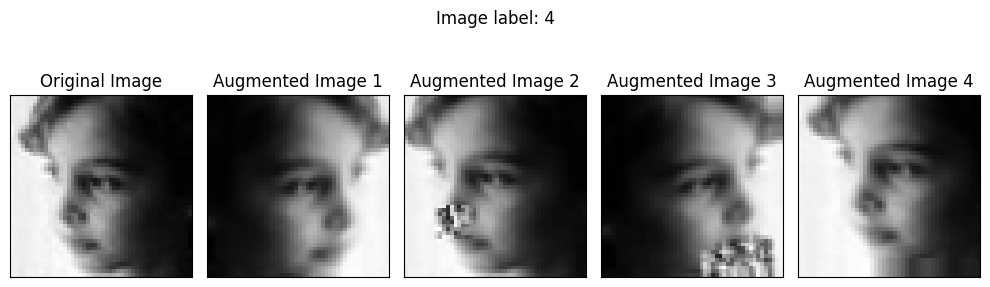

In [11]:
plot.plot_augmentation(augment_tf, apply_landmark_tf=True)

### 2. Class Weights

#### 2a. Plot Dataset 

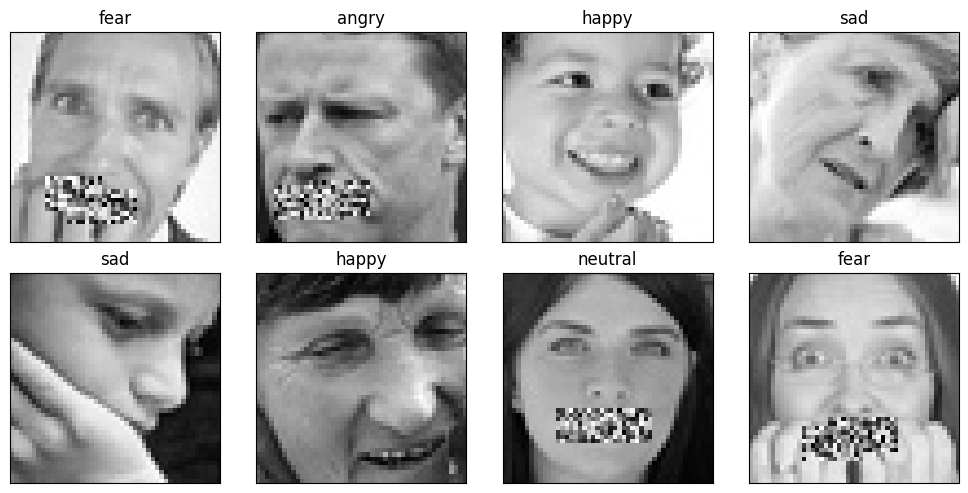

In [5]:
plot.plot_fer_dataset(train_loader)

#### 2b. Create Class Weights for Imbalanced Data

tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8491, 1.2934, 0.8260],
       device='cuda:0')


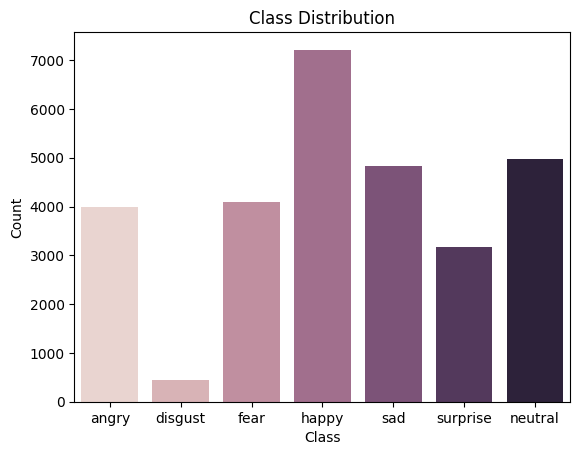

In [6]:
train_class_weights = plot.get_class_weights(DEVICE)
print(train_class_weights)

### 3. Train and Evaluate Functions

In [7]:
class EarlyStopper:
    def __init__(self, patience=30, min_delta=0):
        '''
        Arguments:
            patience (int): number of times to allow for no improvement before stopping the execution
            min_delta (float): minimum change counted as an improvement
        '''
        self.patience = patience 
        self.min_delta = min_delta
        self.counter = 0 # internal counter
        self.min_validation_loss = np.inf

    # Return True when validation loss is not decreased by `min_delta` `patience` times 
    def early_stop(self, validation_loss):
        if ((validation_loss + self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif ((validation_loss + self.min_delta) > self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    def get_patience(self):
        return self.patience

def run_model(model, optimizer, train_loader, valid_loader, criterion, scheduler, scaler, num_epochs, model_name, tf_name):
    print(f'Training {model_name} with transform {tf_name} on {DEVICE}')
    model.to(DEVICE)
    best_accuracy_val = 0.0
    train_acc = []
    train_loss = []
    valid_acc = []
    valid_loss = []
    best_y_true = []
    best_y_pred = []
    early_stopper = EarlyStopper()
    for epoch in range(num_epochs):
        print('.' * 64)
        print(f"--- Epoch {epoch + 1}/{num_epochs} ---")
        
        tr_accuracy, tr_loss = loops.train_model(model, train_loader, optimizer, criterion, scaler, epoch, num_epochs)
        print(f'train_loss: {tr_loss:.4f} - train_accuracy: {tr_accuracy:.4f}')
        
        val_accuracy, val_loss, y_true, y_pred = loops.evaluate_model(model, valid_loader, criterion)
        
        # Update learning rate
        prev_lr = scheduler.get_last_lr()[0]
        scheduler.step(val_loss)
        curr_lr = scheduler.get_last_lr()[0]
        
        if prev_lr > curr_lr:  
            print(f'Updating lr {prev_lr}->{curr_lr}')
        
        # Update best model on validation dataset
        if val_accuracy > best_accuracy_val:
            best_y_true = y_true
            best_y_pred = y_pred
            best_accuracy_val = val_accuracy
            torch.save(model.state_dict(), f'./models/outputs/{model_name}_{tf_name}_best_valid.pth')

        train_acc.append(tr_accuracy)
        train_loss.append(tr_loss)
        valid_acc.append(val_accuracy)
        valid_loss.append(val_loss)
        
        # Early stopping
        if early_stopper.early_stop(val_loss):
            print(f'Stopping early at Epoch {epoch + 1}, min val loss failed to decrease after {early_stopper.get_patience()} epochs')
            break

    return {
        'train_accuracy': train_acc,
        'train_loss': train_loss,
        'valid_accuracy': valid_acc,
        'valid_loss': valid_loss,
        'y_true': best_y_true,
        'y_pred': best_y_pred
    }

### 4. Train Model

In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler

Run the cell of a model. Available models:
- VGGNet
- ResNet50
- EfficientNetB0

In [ ]:
# VGGNet
from models import vgg
model = vgg.Vgg()
model_name = 'VGGNet'

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=HPS['lr'], momentum=0.9, nesterov=True, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5)
scaler = GradScaler()

In [9]:
# ResNet50
from models import resnet
model = resnet.ResNet50()
model_name = 'ResNet50'

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(model.parameters(), lr=HPS['lr'], weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5)
scaler = GradScaler()

In [ ]:
# EfficientNetB0
from models import efn
model = efn.EfficientNetB0()
model_name = 'EfficientNetB0'

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(model.parameters(), lr=HPS['lr'], weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5)
scaler = GradScaler()

In [10]:
results = run_model(model, optimizer, train_loader, valid_loader, criterion, scheduler, scaler, HPS['num_epochs'], model_name, tf_name)

Training ResNet50 with transform simple on cuda
................................................................
--- Epoch 1/300 ---


train_loss: 0.0419 - train_accuracy: 0.1491
validation_loss: 0.7728 - valid_accuracy: 0.1694
................................................................
--- Epoch 2/300 ---


KeyboardInterrupt: 

### 5. Model Evaluation

In [ ]:
plot.plot_training_history(results)

In [ ]:
plot.plot_confusion_matrix(results)

In [ ]:
plot.display_classification_report(results)

### 6. Model Predictions

In [ ]:
# Load model for prediction
MODEL_PATH = './models/outputs/ResNet50_simple_best_valid.pth'
model = resnet.ResNet50()
model.load_state_dict(torch.load(MODEL_PATH))


In [ ]:
# Plot predictions
plot.plot_predictions(model, test_loader, DEVICE)